In [127]:
import warnings
warnings.filterwarnings('ignore')

In [128]:
import tensorflow as tf
import os
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

In [129]:
# Set path to data directory
data_dir = 'data'
data = r'C:\Users\user\Downloads\NLP by kris\ImageClassification-main\ImageClassification-main\data'

In [130]:
# Configure GPU memory growth if available
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [131]:
# List of valid image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [132]:
# Inspect data folders
print("Data directories:", os.listdir(data))
print("Sample happy images:", os.listdir(os.path.join(data, 'happy'))[:5])  # Show first 5 images

Data directories: ['happy', 'sad']
Sample happy images: ['05-12-21-happy-people.jpg', '07-120104-happy_people_are_not_nice_people.jpg', '1-2.jpg', '1000_F_42220133_toAU6USGY9jVr2XJFLssfG00cSYIJ173.jpg', '11-Habits-of-Truly-Happy-People.jpg']


In [133]:
# Clean up dataset by removing invalid images
for image_class in os.listdir(data):
    for image in os.listdir(os.path.join(data, image_class)):
        image_path = os.path.join(data, image_class, image)
        try:
            img = cv2.imread(image_path)
            if img is None:
                print(f"Could not read image {image_path}")
                os.remove(image_path)  # Fixed typo: changed os.revome to os.remove
                continue
                
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)  # Fixed typo: changed os.revome to os.remove
        except Exception as e:
            print(f'Issue with image {image_path}: {str(e)}')  # Fixed string formatting
            # os.remove(image_path)

# Remove Dodgy images

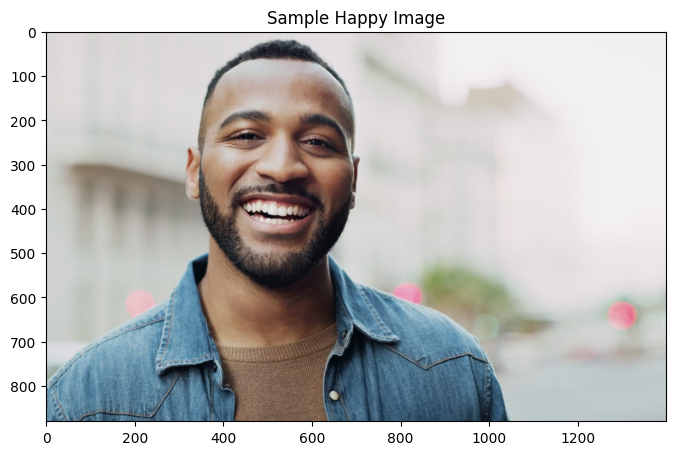

In [134]:
# Display sample image to verify data
sample_img = cv2.imread(os.path.join(data, 'happy', os.listdir(os.path.join(data, 'happy'))[0]))
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
plt.title("Sample Happy Image")
plt.show()


In [135]:
# Load data using TensorFlow's utility
# Note: Keep target size consistent throughout training and prediction (256x256)
data = tf.keras.utils.image_dataset_from_directory(
    data,
    image_size=(256, 256),  # Ensure consistent size
    batch_size=32,
    shuffle=True,
    seed=123
)

Found 171 files belonging to 2 classes.


In [136]:
# Get class names and print them
class_names = data.class_names
print("Class names:", class_names)

Class names: ['happy', 'sad']


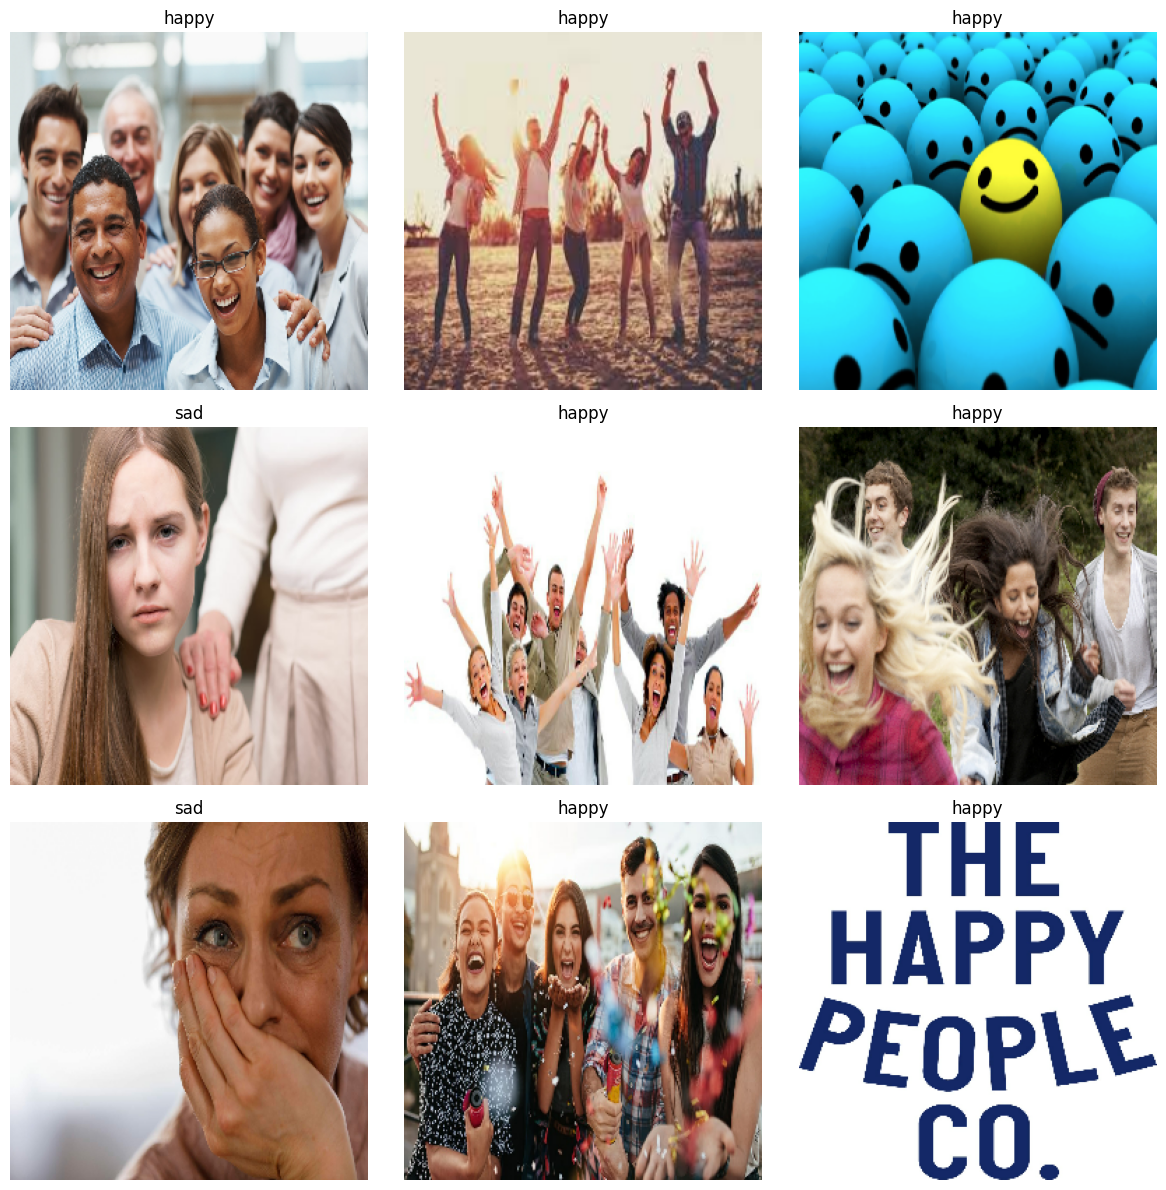

In [137]:
# Visualize a batch of training data
plt.figure(figsize=(12, 12))
for images, labels in data.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [138]:
# Normalize pixel values to [0,1]
data = data.map(lambda x, y: (x/255.0, y))

In [139]:
# Split into train, validation, and test sets
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

In [140]:
print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

Train size: 4, Val size: 1, Test size: 1


In [141]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [142]:
# Define the CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [143]:
model = Sequential([
    # Start with same architecture but add regularization
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Add dropout for regularization
    Dropout(0.2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification: 0=sad, 1=happy
])

In [144]:
# Compile model with binary crossentropy (for binary classification)
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [145]:
# Print model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 128)      

In [146]:
# Set up TensorBoard for visualization
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [147]:
# Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [161]:
# Train the model
history = model.fit(
    train,
    epochs=25,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping]
)

Epoch 1/25
4/4 [==============================] - 98s 12s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/25
4/4 [==============================] - 30s 7s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 3/25
4/4 [==============================] - 34s 8s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 8.3494e-04 - val_accuracy: 1.0000
Epoch 4/25
4/4 [==============================] - 45s 10s/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 5/25
4/4 [==============================] - 45s 10s/step - loss: 0.0208 - accuracy: 0.9922 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/25
4/4 [==============================] - 48s 8s/step - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 7/25
4/4 [==============================] - 27s 7s/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 0.0053 - val_accuracy: 1.0000
Epoch 8/25
4/4 [===========

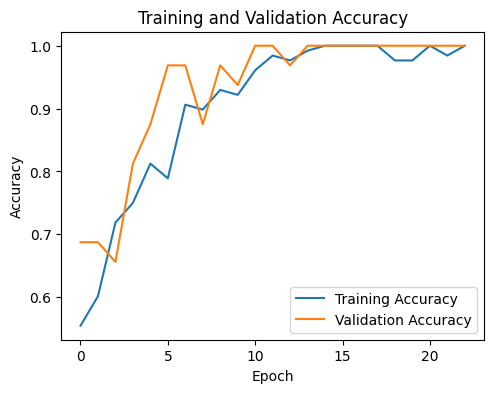

In [150]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

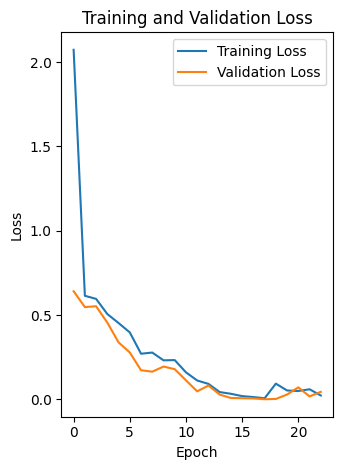

In [151]:
# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
# Evaluate on test set
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [153]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [154]:
# Evaluate model on test dataset
for x, y in test:
    # Make predictions
    yhat = model.predict(x)
    # Update metrics
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

1/1 [==============================] - 4s 4s/step


In [155]:
print(f"Precision: {precision.result().numpy():.4f}")
print(f"Recall: {recall.result().numpy():.4f}")
print(f"Accuracy: {accuracy.result().numpy():.4f}")

Precision: 1.0000
Recall: 1.0000
Accuracy: 1.0000


In [156]:
# Save the model
model.save("happy_sad_classification_model.h5")
print("Model saved successfully!")

Model saved successfully!


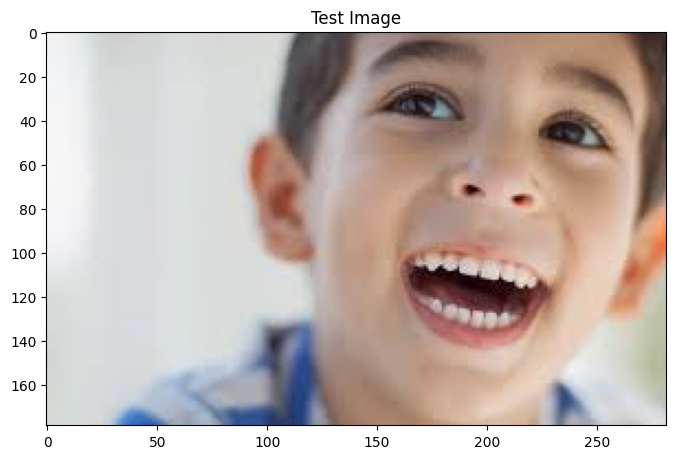

In [157]:
# Test with a single image
test_img_path = r'C:\Users\user\Downloads\NLP by kris\ImageClassification-main\ImageClassification-main\happytest.jpg'
img = cv2.imread(test_img_path)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Test Image")
plt.show()

In [158]:
# Preprocess the test image
test_img = cv2.resize(img, (256, 256))
test_img = test_img / 255.0
test_img = np.expand_dims(test_img, axis=0)

In [159]:
# Make prediction
prediction = model.predict(test_img)[0][0]
pred_class = "Happy" if prediction >= 0.5 else "Sad"
conf_pct = prediction if prediction >= 0.5 else 1 - prediction
print(f"Prediction: {pred_class} with {conf_pct*100:.2f}% confidence")

1/1 [==============================] - 0s 197ms/step
Prediction: Happy with 95.89% confidence


In [160]:
# Save the model without compiling
model.save("image_classification_model.h5", include_optimizer=False)